(309, 6)
(309,)
MSE: 3.5885
R2: 0.2874


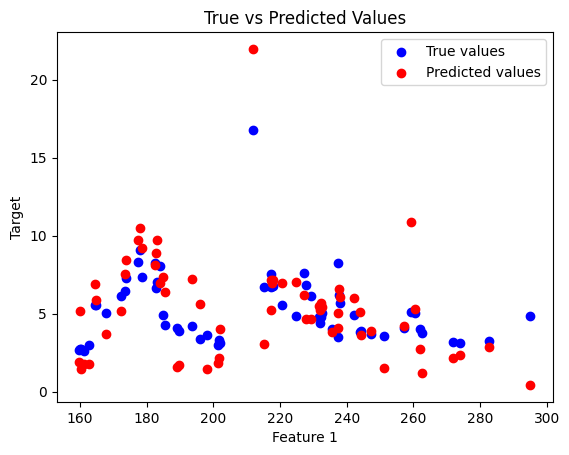

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


data = pd.read_csv("../../data/merged_macroeconomic_credit.csv")

data['Month_End'] = pd.to_datetime(data['Month_End'])
data.set_index('Month_End', inplace=True)

# Preparing
X = data[['Consumer Price Index for All Urban Consumers All Items in U.S. City Average_CPIAUCSL', 
          'Federal Funds Effective Rate _FEDFUNDS', 
          'Industrial Production Total Index_INDPRO', 
          'Leading Indicators OECD Reference Series Gross Domestic Product (GDP) Original Series for the Euro Area (19 Countries)EA19LORSGPORGYSAM', 
          'Unemployment Rate_UNRATE', 
          'University of Michigan Consumer Sentiment_UMCSENT']]
y = data['BAMLH0A0HYM2']

# Dropping missing values from X and aligning y accordingly
X = X.dropna()
y = y[X.index]
print(X.shape)
print(y.shape)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 80% train, 20% test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Polynomial features (deg=3)
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

#linear regression model to polynomial features
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Predictions
y_pred = poly_reg.predict(X_test_poly)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

# Plots
plt.scatter(X_test.iloc[:, 0], y_test, color='blue', label='True values')  # Use the first feature of X_test
plt.scatter(X_test.iloc[:, 0], y_pred, color='red', label='Predicted values')  # Same for predictions
plt.xlabel('Feature 1')  # Label x-axis
plt.ylabel('Target')  # Label y-axis
plt.title('True vs Predicted Values')
plt.legend()
plt.show()


Polynomial Regression (deg=3): Features scaled and expanded, data split into train-test, regression performed, and metrics recorded.

Best parameters from GridSearchCV: {'alpha': 0.01, 'degree': 2}
MSE: 1.0406
R2: 0.7934


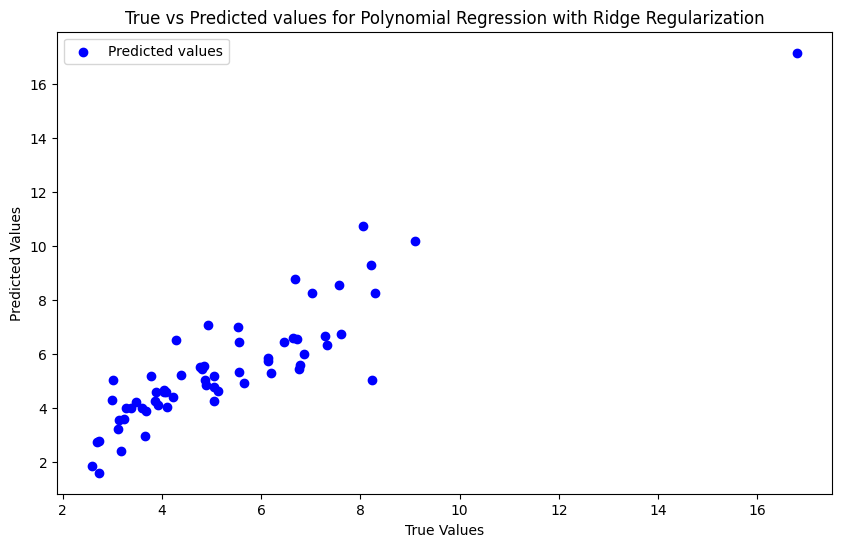

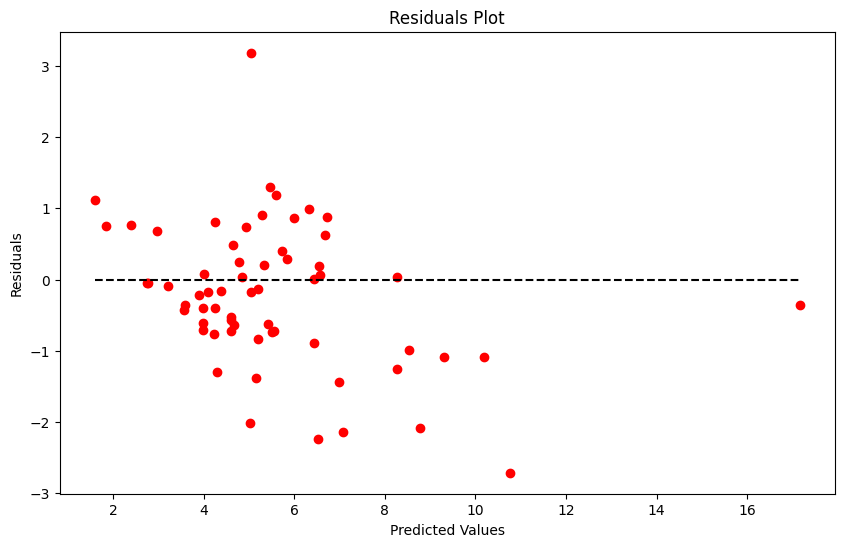

In [ ]:
#Scaling 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Polynomial feature transformation
poly = PolynomialFeatures()
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Ridge Regression Model
ridge = Ridge()

# Hyperparameter tuning for regularization strength (a) and polynomial degree
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100],  
    'degree': [2, 3, 4, 5]  
}

# Preprocessing and modeling in GridSearchCV
def polynomial_ridge(alpha, degree, X_train, X_test):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Ridge regression with the current alpha
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_poly, y_train)
    return ridge_model.predict(X_test_poly)

# GridSearchCV with a custom estimator function
from sklearn.base import BaseEstimator, TransformerMixin
class PolynomialRidgeEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=1.0, degree=2):
        self.alpha = alpha
        self.degree = degree
        self.poly = PolynomialFeatures(degree=self.degree)
        self.ridge = Ridge(alpha=self.alpha)

    def fit(self, X, y):
        X_poly = self.poly.fit_transform(X)
        self.ridge.fit(X_poly, y)
        return self

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return self.ridge.predict(X_poly)

# Finding the best parameters
grid_search = GridSearchCV(PolynomialRidgeEstimator(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)


best_model = grid_search.best_estimator_

# Prediction
y_pred = best_model.predict(X_test_scaled)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Best parameters from GridSearchCV: {grid_search.best_params_}")
print(f"MSE: {mse:.4f}")
print(f"R2: {r2:.4f}")

# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted values for Polynomial Regression with Ridge Regularization')
plt.legend()
plt.show()

# Plotting residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='red')
plt.hlines(0, min(y_pred), max(y_pred), colors='black', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

^Improved results: Polynomial Regression implemented using Ridge. features transformed, expanded, and scaled. HP tuning done using GridSearch.